# YouTube Comment Cleaning and Exploration

Takes data from a CSV file and cleans the data to isolate comments of interest

In [1]:
import re
import japanize_matplotlib
import matplotlib.pyplot as plt
import nagisa
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from functools import reduce
from operator import add
from pathlib import Path

NumExpr defaulting to 8 threads.


In [2]:
input_path = Path('Resources/youtube_comments.csv')
comments_df = pd.read_csv(input_path, index_col=0)

comments_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type
0,mwamjapan,Jb6Zlg30rgk,10,This season is going to be a masterpiece <3,2023-04-16T15:39:10Z,top-level
1,mwamjapan,Jb6Zlg30rgk,10,Every season is masterpiece 🔥🔥🔥,2023-04-17T16:41:52Z,reply
2,mwamjapan,Jb6Zlg30rgk,10,@HM cry about it,2023-04-17T16:15:19Z,reply
3,mwamjapan,Jb6Zlg30rgk,10,@HM dude demon slayer has no story but it has ...,2023-04-17T15:44:29Z,reply
4,mwamjapan,Jb6Zlg30rgk,10,@HM 🙂🙃😒😒😒,2023-04-17T13:44:05Z,reply
5,mwamjapan,Jb6Zlg30rgk,10,Honestamente no entiendo porqué esta canción r...,2023-04-17T03:58:25Z,top-level
6,mwamjapan,Jb6Zlg30rgk,10,​@みっくん𓈒𓂂◌𝙼𝙸𝚈𝚄 llora pues,2023-04-17T17:15:35Z,reply
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply
8,mwamjapan,Jb6Zlg30rgk,10,悩めば、イイ！,2023-04-17T14:53:19Z,reply
9,mwamjapan,Jb6Zlg30rgk,10,@みっくん𓈒𓂂◌𝙼𝙸𝚈𝚄 ニワカほどそう言うよね！,2023-04-17T13:11:13Z,reply


In [3]:
# RE patterns needed for JP text
hiragana = r'\u3041-\u3096'
katakana = r'\u30A1-\u30F6'
kanji = r'\u3006\u4E00-\u9FFF'

# Matches to test for existence of text that uses a Japanese script
jp_text = rf'[{hiragana}{katakana}{kanji}]'

# Accepted characters
accepted_char = rf'[a-zA-Z0-9\u30FC\u3005{hiragana}{katakana}{kanji}]'

In [4]:
# Remove @username from replies
# Done before rest of cleaning to ensure a username using a Japanese script doesn't pass filter
comments_df['text'] = comments_df['text'].str.replace(r'@\S+\s', '', regex=True)

In [5]:
# Filter out comments that don't have any Japanese characters
has_jp_char = comments_df.loc[comments_df['text'].str.contains(jp_text, regex=True)]

has_jp_char.sample(10)

,channel,video_id,category_id,text,date_published,comment_type
77,Kenshi Yonezu 米津玄師,QeqbN1IZVpk,10,自分とはかけ離れた日常を送っているであろう米津さんの感じていることや考えていることを、本人の...,2023-04-10T02:35:18Z,top-level
97,Kenshi Yonezu 米津玄師,QeqbN1IZVpk,10,なんて素敵な声❤\nずっと聞いていたい。,2023-04-09T11:12:26Z,top-level
80,ABEMA チャンスの時間 【公式】,2ABNfKdqEdE,24,島田秀平面白すぎる,2023-04-15T13:06:29Z,top-level
20,ちゃんねる鰐,urW-CCjGxVw,15,どの子も本当に魅力的でますます行きたくなってくる,2023-04-13T11:17:44Z,top-level
170,東海オンエア,I0jAyfCsL_8,23,とにかく野球を楽しんでくれて嬉しい\n名商野球部も動画の終わり方わかってるな〜,2023-04-17T00:07:39Z,top-level
43,KAI Channel / 朝倉海,PKiHsPvavgA,24,田上こゆる選手が応募してるのは驚いた。 後、かずややねんさんや邪鬼さんや虎之介君等、強いし面...,2023-04-12T15:06:58Z,top-level
99,Paradi Show,Uanit31XcdQ,22,初見です！わかる🤣私も美味しいパン好きです。めっちゃ美味しそう🤤,2023-04-15T15:08:00Z,top-level
44,ガンダムチャンネル,0Zmt74GeVpY,1,2期のオープニングマジで好きだわ,2023-04-09T08:41:44Z,top-level
171,東海オンエア,ogfbE7ymLRU,23,ゆめまるは普段暇さえあれば携帯触ってるイメージ笑,2023-04-13T05:29:04Z,top-level
116,SUPER GT Official Channel,4fx_0IRdvSc,17,1:52ドライでもBSトヨタトムスをブチ抜いたよ？,2023-04-16T13:09:15Z,reply


In [6]:
# Remove other unnecessary characters - 
def clean_text(text):
    
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\t', '', text)
    text = re.sub(r'\r', '', text)
    text = re.sub(r'https?://[a-zA-Z0-9.-]*[/?[a-zA-Z0-9.-_]*]*', '', text)
    text = re.sub(r'笑+', '笑', text)
    
    filtered_text = ''
    
    for char in text:
        if re.match(accepted_char, char):
            
            filtered_text += char
            
    return filtered_text

In [7]:
# Clean
cleaned_df = has_jp_char.copy()
cleaned_df['text'] = cleaned_df['text'].apply(clean_text)

cleaned_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level
45,mwamjapan,Jb6Zlg30rgk,10,全く仰るとおりで作中にはいろんな絆ノ奇跡がありますよね特に刀鍛冶の里編のラストは絆ノ奇跡その...,2023-04-17T13:48:13Z,reply
46,mwamjapan,Jb6Zlg30rgk,10,我が命果てようとも繋いでいこう自分が志半ばで死んでも繋いだ命がきっと果たしてくれると二話で炭...,2023-04-17T13:37:24Z,reply
47,mwamjapan,Jb6Zlg30rgk,10,我が命果てようともには無一郎を思い浮かべました,2023-04-17T13:07:22Z,reply
48,mwamjapan,Jb6Zlg30rgk,10,鬼滅の刃には色んな絆ノ奇跡がありますね,2023-04-17T11:53:14Z,reply


In [8]:
# Check size of DF
cleaned_df.shape

(11297, 6)

In [9]:
# Check for null values
cleaned_df.isna().sum()

channel           0
video_id          0
category_id       0
text              0
date_published    0
comment_type      0
dtype: int64

In [10]:
# Check unique values in each
cleaned_df.nunique()

channel              82
video_id             92
category_id          12
text              10659
date_published    11104
comment_type          2
dtype: int64

In [11]:
# Check amounts of top-level vs. replies for comments
cleaned_df['comment_type'].value_counts()

top-level    8320
reply        2977
Name: comment_type, dtype: int64

In [12]:
# Tokenize text
analysis_df = cleaned_df.copy()
analysis_df['tokens'] = analysis_df['text'].apply(lambda x: nagisa.tagging(x))

analysis_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type,tokens
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply,たか/名詞 が/助詞 OP/名詞 で/助詞 世界/名詞 観/接尾辞 が/助詞 壊れる/動詞 ...
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply,悩め/動詞 ば/助詞 イイ/形容詞
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply,ニワカ/形状詞 ほど/助詞 そう/副詞 言う/動詞 よ/助詞 ね/助詞
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply,珍しく/形容詞 ショート/名詞 動画/名詞 が/助詞 出/動詞 て/助動詞 ます/助動詞 ね...
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply,めっちゃ/副詞 同意/名詞
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level,milet/名詞 と/助詞 の/助詞 コラボ/名詞 に/助詞 は/助詞 最初/名詞 びっくり...
45,mwamjapan,Jb6Zlg30rgk,10,全く仰るとおりで作中にはいろんな絆ノ奇跡がありますよね特に刀鍛冶の里編のラストは絆ノ奇跡その...,2023-04-17T13:48:13Z,reply,全く/副詞 仰る/動詞 とおり/名詞 で/助詞 作中/名詞 に/助詞 は/助詞 いろんな/連...
46,mwamjapan,Jb6Zlg30rgk,10,我が命果てようとも繋いでいこう自分が志半ばで死んでも繋いだ命がきっと果たしてくれると二話で炭...,2023-04-17T13:37:24Z,reply,我が/連体詞 命/名詞 果てよう/動詞 と/助詞 も/助詞 繋い/動詞 で/助詞 いこう/動...
47,mwamjapan,Jb6Zlg30rgk,10,我が命果てようともには無一郎を思い浮かべました,2023-04-17T13:07:22Z,reply,我が/連体詞 命/名詞 果てよう/動詞 とも/名詞 に/助詞 は/助詞 無一郎/名詞 を/助...
48,mwamjapan,Jb6Zlg30rgk,10,鬼滅の刃には色んな絆ノ奇跡がありますね,2023-04-17T11:53:14Z,reply,鬼滅/名詞 の/助詞 刃/名詞 に/助詞 は/助詞 色んな/連体詞 絆ノ/名詞 奇跡/名詞 ...


In [13]:
# Created filtered column
analysis_df['filtered_tokens'] = (analysis_df['text']
                                  .apply(lambda x: nagisa.filter(x, filter_postags=['助詞', '助動詞', 'ローマ字文',
                                                                                    '未知語', 'URL'])))

analysis_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type,tokens,filtered_tokens
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply,たか/名詞 が/助詞 OP/名詞 で/助詞 世界/名詞 観/接尾辞 が/助詞 壊れる/動詞 ...,たか/名詞 OP/名詞 世界/名詞 観/接尾辞 壊れる/動詞 アニメ/名詞 ない/形容詞 は...
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply,悩め/動詞 ば/助詞 イイ/形容詞,悩め/動詞 イイ/形容詞
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply,ニワカ/形状詞 ほど/助詞 そう/副詞 言う/動詞 よ/助詞 ね/助詞,ニワカ/形状詞 そう/副詞 言う/動詞
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply,珍しく/形容詞 ショート/名詞 動画/名詞 が/助詞 出/動詞 て/助動詞 ます/助動詞 ね...,珍しく/形容詞 ショート/名詞 動画/名詞 出/動詞 最高/名詞 すぎる/動詞
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply,めっちゃ/副詞 同意/名詞,めっちゃ/副詞 同意/名詞
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level,milet/名詞 と/助詞 の/助詞 コラボ/名詞 に/助詞 は/助詞 最初/名詞 びっくり...,milet/名詞 コラボ/名詞 最初/名詞 びっくり/名詞 し/動詞 声/名詞 相性/名詞 ...
45,mwamjapan,Jb6Zlg30rgk,10,全く仰るとおりで作中にはいろんな絆ノ奇跡がありますよね特に刀鍛冶の里編のラストは絆ノ奇跡その...,2023-04-17T13:48:13Z,reply,全く/副詞 仰る/動詞 とおり/名詞 で/助詞 作中/名詞 に/助詞 は/助詞 いろんな/連...,全く/副詞 仰る/動詞 とおり/名詞 作中/名詞 いろんな/連体詞 絆ノ/名詞 奇跡/名詞 ...
46,mwamjapan,Jb6Zlg30rgk,10,我が命果てようとも繋いでいこう自分が志半ばで死んでも繋いだ命がきっと果たしてくれると二話で炭...,2023-04-17T13:37:24Z,reply,我が/連体詞 命/名詞 果てよう/動詞 と/助詞 も/助詞 繋い/動詞 で/助詞 いこう/動...,我が/連体詞 命/名詞 果てよう/動詞 繋い/動詞 いこう/動詞 自分/名詞 志/名詞 半ば...
47,mwamjapan,Jb6Zlg30rgk,10,我が命果てようともには無一郎を思い浮かべました,2023-04-17T13:07:22Z,reply,我が/連体詞 命/名詞 果てよう/動詞 とも/名詞 に/助詞 は/助詞 無一郎/名詞 を/助...,我が/連体詞 命/名詞 果てよう/動詞 とも/名詞 無一郎/名詞 思い浮かべ/動詞
48,mwamjapan,Jb6Zlg30rgk,10,鬼滅の刃には色んな絆ノ奇跡がありますね,2023-04-17T11:53:14Z,reply,鬼滅/名詞 の/助詞 刃/名詞 に/助詞 は/助詞 色んな/連体詞 絆ノ/名詞 奇跡/名詞 ...,鬼滅/名詞 刃/名詞 色んな/連体詞 絆ノ/名詞 奇跡/名詞 あり/動詞


In [14]:
# Use for examining properties of the tokens
test = analysis_df.iloc[0]['filtered_tokens']
test

In [15]:
test.words

['たか', 'OP', '世界', '観', '壊れる', 'アニメ', 'ない', 'はげ', 'たこ']

In [16]:
type(test.words[0])

str

In [17]:
str(test)

'たか/名詞 OP/名詞 世界/名詞 観/接尾辞 壊れる/動詞 アニメ/名詞 ない/形容詞 はげ/名詞 たこ/名詞'

In [43]:
# Extract filtered_tokens into a list
def extract_tokens(df_column):

    token_list = df_column.apply(lambda x: str(x).split()).tolist()
    word_list = reduce(add, token_list)
    
    return word_list

In [44]:
word_list = extract_tokens(analysis_df['filtered_tokens'])

In [45]:
# Get total word count and examine sample of the list
total_words = len(word_list)
print(total_words, word_list[:10])

163957 ['たか/名詞', 'OP/名詞', '世界/名詞', '観/接尾辞', '壊れる/動詞', 'アニメ/名詞', 'ない/形容詞', 'はげ/名詞', 'たこ/名詞', '悩め/動詞']


In [20]:
# Count and sort by occurrences
def count_words(word_list):
    
    counter = Counter(word_list)
    freq_list = counter.most_common()
    
    return freq_list

In [21]:
# Organize data as a DF display
def display_freq(freq_list):
    
    freq_df = pd.DataFrame.from_records(list(dict(freq_list).items()),
                                        columns=['word', 'count'])
    freq_df[['word', 'pos']] = freq_df['word'].str.split('/', expand=True)
    freq_df = freq_df[['word', 'pos', 'count']]
    
    # Remove entries that are only numbers
    freq_df = freq_df.loc[~freq_df['word'].str.contains('\d+')].reset_index(drop=True)
    
    return freq_df

## Frequency for entire dataset

Outside of particles, auxiliary verbs and roman digits the count of all unique words is considered - including very common words like する as well as internet colloquialisms such as w (indicates laughter similar to "lol").
Data is sorted into the most common words for the dataset in descending order. 

In [46]:
# Calculating totals for entire dataset
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)

freq_df.head(25)

,word,pos,count
0,し,動詞,3578
1,さん,接尾辞,2149
2,お,接頭辞,1439
3,ちゃん,接尾辞,1182
4,見,動詞,1096
5,この,連体詞,844
6,ありがとう,感動詞,813
7,いい,形容詞,796
8,好き,形状詞,788
9,ない,形容詞,786


In [23]:
freq_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17501 entries, 0 to 17500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    17501 non-null  object
 1   pos     17501 non-null  object
 2   count   17501 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 410.3+ KB


In [24]:
def get_percentages(freq_df):
    
    total_words = sum(freq_df['count'])
    freq_df['freq_percentage'] = freq_df['count'] / total_words
    
    return freq_df

In [25]:
freq_df = get_percentages(freq_df)

freq_df.head(25)

,word,pos,count,freq_percentage
0,し,動詞,3578,0.023616
1,さん,接尾辞,2149,0.014184
2,お,接頭辞,1439,0.009498
3,ちゃん,接尾辞,1182,0.007802
4,見,動詞,1096,0.007234
5,この,連体詞,844,0.005571
6,ありがとう,感動詞,813,0.005366
7,いい,形容詞,796,0.005254
8,好き,形状詞,788,0.005201
9,ない,形容詞,786,0.005188


In [26]:
# Summary stats
freq_df.describe()

,count,freq_percentage
count,17501.000000,17501.000000
mean,8.657048,0.000057
std,50.041541,0.000330
min,1.000000,0.000007
25%,1.000000,0.000007
50%,1.000000,0.000007
75%,4.000000,0.000026
max,3578.000000,0.023616


In [27]:
# Examine breakdown of each POS
parts_of_speech = freq_df.groupby('pos').agg(
    unique_terms = ('word', 'count'),
    total = ('count', 'sum'),
    percent = ('freq_percentage', 'sum'))

# Sort the result
parts_of_speech = (parts_of_speech.reset_index()
                       .sort_values(['total'], ascending=False)
                       .set_index(['pos']))

parts_of_speech

,unique_terms,total,percent
pos,,,
名詞,11099,72227,0.476724
動詞,3299,35547,0.234623
形容詞,625,10643,0.070248
接尾辞,385,9980,0.065872
副詞,580,6560,0.043298
形状詞,414,5406,0.035682
代名詞,84,3420,0.022573
接頭辞,83,2468,0.016290
連体詞,33,1854,0.012237


### Plotting frequency

Uses multiple bar charts using subplots to visualize top 100 most used words - idea and code is adapted from Boriharn K from Towards Data Science

In [28]:
def plot_frequency_bars(freq_df, title):
    # Split DF into 5 equal sections
    # And make a list of the start and end indices for each subsection
    index_list = [[i[0], i[-1] + 1] for i in np.array_split(range(100), 5)]
    max_val, min_val = freq_df['count'].max(), freq_df.iloc[99]['count']

    fig, axs = plt.subplots(1, 5, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)
    sns.set(font='IPAexGothic')

    # Create a dictionary for color mappings
    scaled_count = freq_df.iloc[0:99]['count'] // min_val
    pal = list(sns.color_palette(palette='crest',
                                 n_colors=scaled_count.max()).as_hex())
    color_dict = dict(enumerate(pal, 1))

    for col, i in enumerate(index_list):
        df = freq_df.iloc[i[0]:i[-1]]
        label = [f'{word}:{count}' for word, count in zip(df['word'], df['count'])]
        colors = [color_dict.get(val // min_val) for val in df['count']]
        x = list(df['count'])
        y = list(range(20))

        sns.barplot(x=x, y=y, alpha=0.9, orient='h',
                   ax=axs[col], palette=colors)
        axs[col].set_xlim(0, max_val + 1)
        axs[col].set_yticklabels(label, fontsize=12)

    plt.tight_layout()
    plt.show()

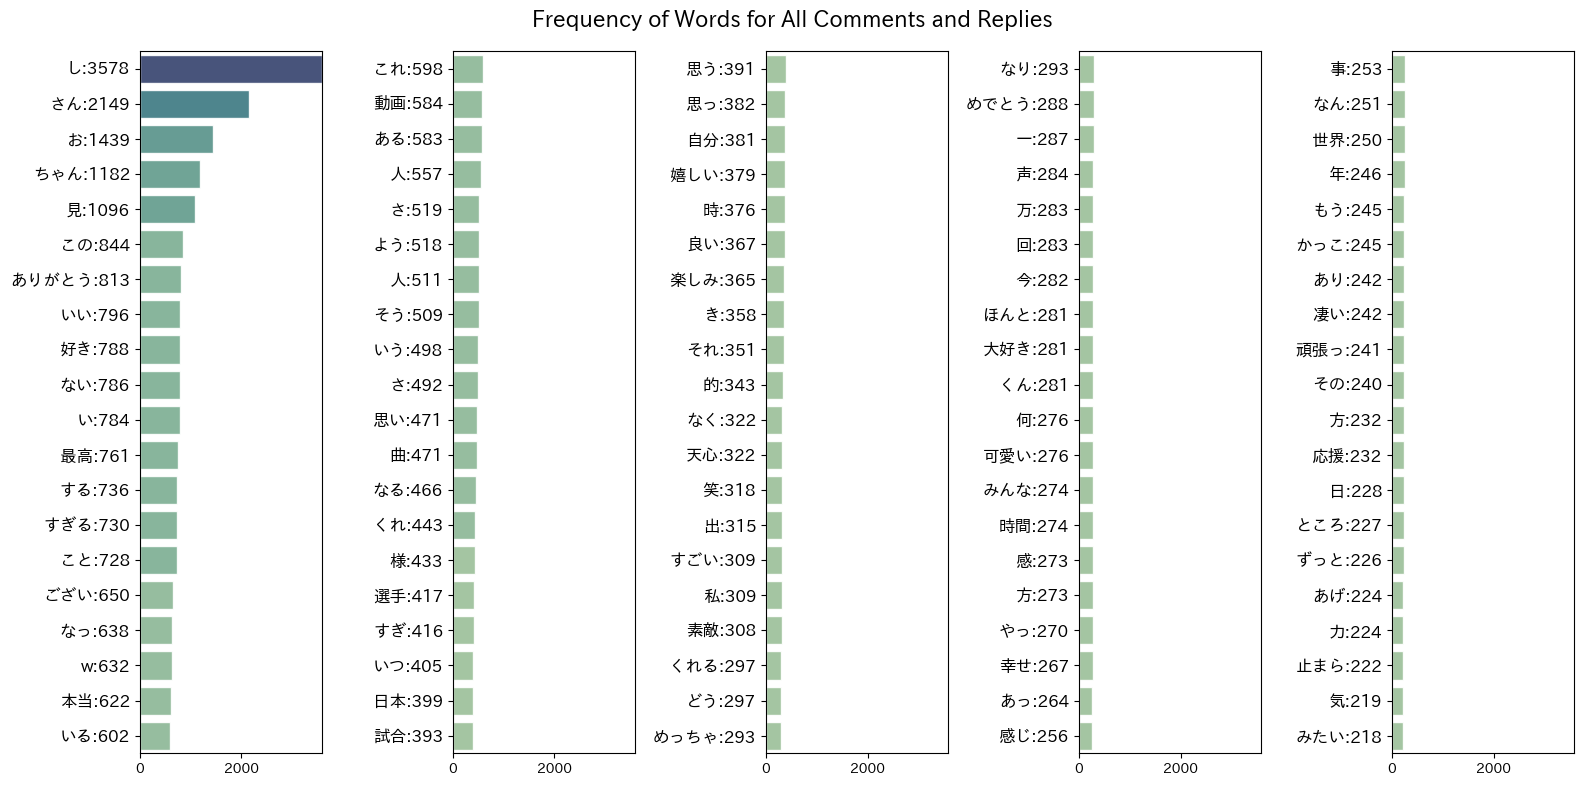

In [29]:
# All YouTube comments
plot_frequency_bars(freq_df, 'Frequency of Words for All Comments and Replies')

## Frequency by Comment Type

### Top-level YouTube Comments
Can have replies associated with them, but can also not.

In [30]:
# Filter for top-level comments only
top_level_df = analysis_df.loc[analysis_df['comment_type'] == 'top-level']

print(top_level_df.shape)
top_level_df.head()

(8320, 8)


,channel,video_id,category_id,text,date_published,comment_type,tokens,filtered_tokens
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level,milet/名詞 と/助詞 の/助詞 コラボ/名詞 に/助詞 は/助詞 最初/名詞 びっくり...,milet/名詞 コラボ/名詞 最初/名詞 びっくり/名詞 し/動詞 声/名詞 相性/名詞 ...
51,mwamjapan,Jb6Zlg30rgk,10,歌詞闇夜を駆け抜けて何処へむかう月明かりだけがただ一つの道標痛みも悲しみも拭いきれずされどこ...,2023-04-17T00:43:46Z,top-level,歌詞/名詞 闇/名詞 夜/名詞 を/助詞 駆け抜け/動詞 て/助詞 何処/代名詞 へ/助詞 ...,歌詞/名詞 闇/名詞 夜/名詞 駆け抜け/動詞 何処/代名詞 むかう/動詞 月明かり/名詞 ...
58,mwamjapan,Jb6Zlg30rgk,10,歌詞です闇夜を駆け抜けて何処へむかう月明かりだけがただ一つの道標痛みも悲しみも拭いきれずされ...,2023-04-17T08:10:12Z,top-level,歌詞/名詞 です/助動詞 闇夜/名詞 を/助詞 駆け抜け/動詞 て/助詞 何処/代名詞 へ/...,歌詞/名詞 闇夜/名詞 駆け抜け/動詞 何処/代名詞 むかう/動詞 月明かり/名詞 ただ/副...
69,mwamjapan,Jb6Zlg30rgk,10,過去のOPがかなり良かったから比べられても仕方ないのに今回も最高だから比べようがないどのOP...,2023-04-17T10:00:33Z,top-level,過去/名詞 の/助詞 OP/名詞 が/助詞 かなり/副詞 良かっ/形容詞 た/助動詞 から/...,過去/名詞 OP/名詞 かなり/副詞 良かっ/形容詞 比べ/動詞 仕方ない/形容詞 今回/名...
71,mwamjapan,Jb6Zlg30rgk,10,manwithさんとmiletさんのmvは大半クールな英語歌詞であるのに対してこのコラボ作品...,2023-04-17T13:41:28Z,top-level,manwith/名詞 さん/接尾辞 と/助詞 milet/名詞 さん/接尾辞 の/助詞 mv...,manwith/名詞 さん/接尾辞 milet/名詞 さん/接尾辞 mv/名詞 大半/名詞 ...


In [31]:
# Extract the filtered tokens into a list
word_list = extract_tokens(top_level_df['filtered_tokens'])

In [32]:
# Count unique words and create a frequency DF
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)
freq_df = get_percentages(freq_df)

freq_df.head(25)

,word,pos,count,freq_percentage
0,し,動詞,2981,0.023711
1,さん,接尾辞,2002,0.015924
2,お,接頭辞,1355,0.010778
3,ちゃん,接尾辞,938,0.007461
4,見,動詞,783,0.006228
5,この,連体詞,746,0.005934
6,好き,形状詞,732,0.005822
7,ありがとう,感動詞,726,0.005775
8,い,動詞,695,0.005528
9,いい,形容詞,678,0.005393


In [33]:
# Get summary stats
freq_df.describe()

,count,freq_percentage
count,15260.000000,15260.000000
mean,8.238598,0.000066
std,45.646877,0.000363
min,1.000000,0.000008
25%,1.000000,0.000008
50%,1.000000,0.000008
75%,4.000000,0.000032
max,2981.000000,0.023711


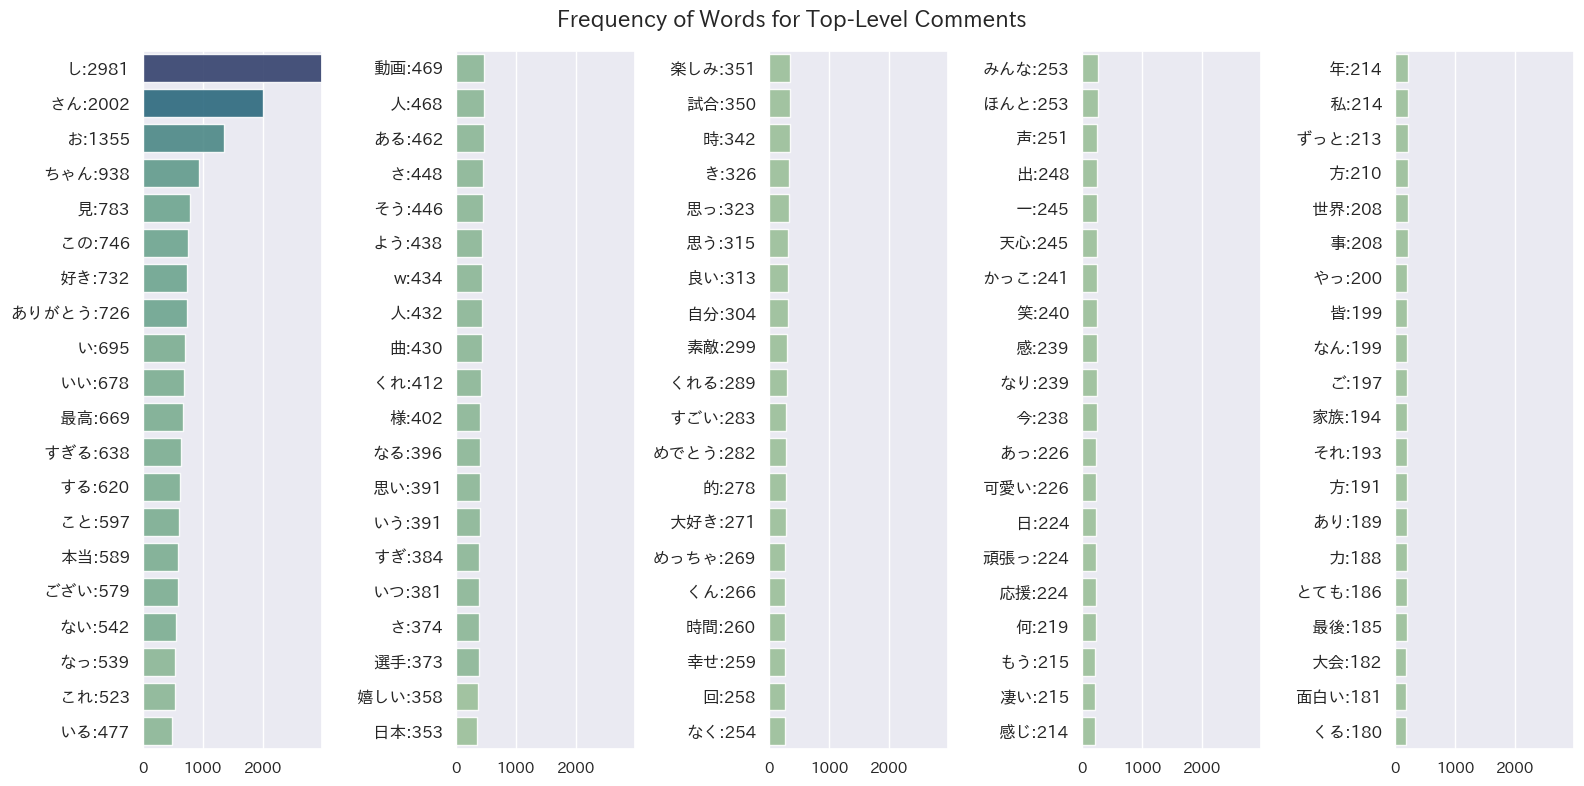

In [34]:
# Generate bar plot
plot_frequency_bars(freq_df, 'Frequency of Words for Top-Level Comments')

### Replies

In [35]:
# Filter for replies only
replies_df = analysis_df.loc[analysis_df['comment_type'] == 'reply']

print(replies_df.shape)
replies_df.head()

(2977, 8)


,channel,video_id,category_id,text,date_published,comment_type,tokens,filtered_tokens
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply,たか/名詞 が/助詞 OP/名詞 で/助詞 世界/名詞 観/接尾辞 が/助詞 壊れる/動詞 ...,たか/名詞 OP/名詞 世界/名詞 観/接尾辞 壊れる/動詞 アニメ/名詞 ない/形容詞 は...
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply,悩め/動詞 ば/助詞 イイ/形容詞,悩め/動詞 イイ/形容詞
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply,ニワカ/形状詞 ほど/助詞 そう/副詞 言う/動詞 よ/助詞 ね/助詞,ニワカ/形状詞 そう/副詞 言う/動詞
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply,珍しく/形容詞 ショート/名詞 動画/名詞 が/助詞 出/動詞 て/助動詞 ます/助動詞 ね...,珍しく/形容詞 ショート/名詞 動画/名詞 出/動詞 最高/名詞 すぎる/動詞
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply,めっちゃ/副詞 同意/名詞,めっちゃ/副詞 同意/名詞


In [36]:
# Extract the filtered tokens into a list
word_list = extract_tokens(replies_df['filtered_tokens'])

In [37]:
# Count unique words and create a frequency DF
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)
freq_df = get_percentages(freq_df)

freq_df.head(25)

,word,pos,count,freq_percentage
0,し,動詞,597,0.023152
1,見,動詞,313,0.012138
2,ない,形容詞,244,0.009462
3,ちゃん,接尾辞,244,0.009462
4,w,記号,198,0.007679
5,万,名詞,193,0.007485
6,どう,副詞,187,0.007252
7,浜辺,名詞,181,0.007019
8,ミナミ,名詞,181,0.007019
9,流出,名詞,181,0.007019


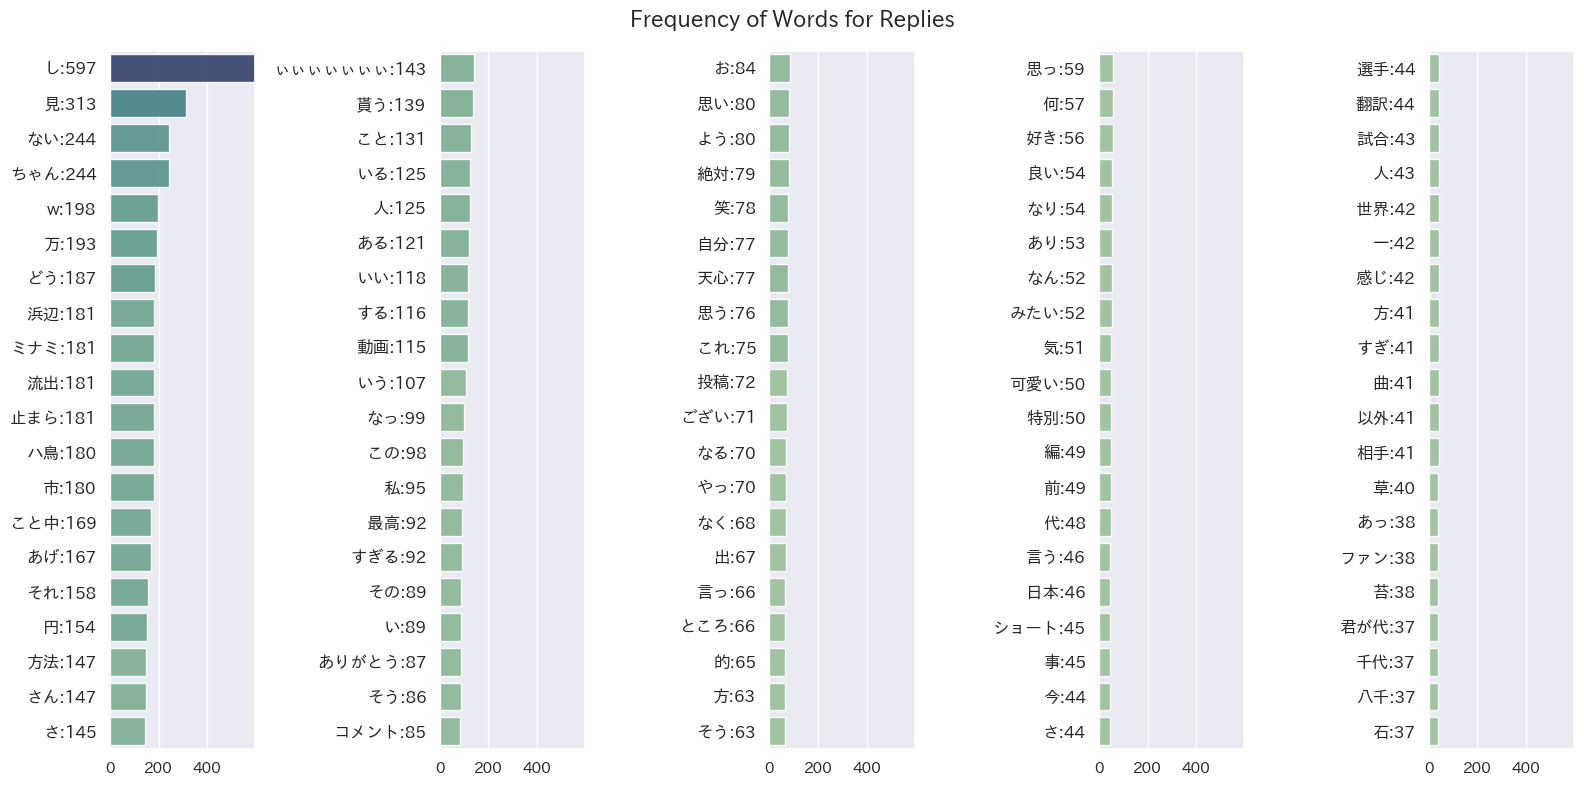

In [38]:
# Generate bar plot
plot_frequency_bars(freq_df, 'Frequency of Words for Replies')

### Notes from this comparison
* Top 10 frequent words very similar for all comments and top-level only; this is mostly unsurprising, as top-level comments make up for 3/4ths of the data.
* Frequency of things like お, さん, ちゃん in top-level likely arise from talking about/directly to the channel, as seen with the music-related comments such as milet-さん
* Six-character repeating half-width い???

## Frequency by Part of Speech

What are the most common words in the following POS categories:
* 名詞 (Nouns)
* 動詞 (Verbs)
* 形容詞 (Adjectives)
* 副詞 (Adverbs)
* 形状詞 (Adjectival Nouns)

In [39]:
def filter_freq_by_pos(freq_df, pos_tag):
    pos_df = freq_df.loc[freq_df['pos'] == pos_tag].reset_index(drop=True)
    
    return pos_df

In [48]:
# Filter for nouns
top_nouns_df = filter_freq_by_pos(freq_df, '名詞')
top_nouns_df.head(25)

,word,pos,count
0,最高,名詞,761
1,こと,名詞,728
2,本当,名詞,622
3,動画,名詞,584
4,人,名詞,557
5,曲,名詞,471
6,選手,名詞,417
7,日本,名詞,399
8,試合,名詞,393
9,自分,名詞,381


In [49]:
# Filter for verbs
top_verbs_df = filter_freq_by_pos(freq_df, '動詞')
top_verbs_df.head(25)

,word,pos,count
0,し,動詞,3578
1,見,動詞,1096
2,い,動詞,784
3,する,動詞,736
4,すぎる,動詞,730
5,ござい,動詞,650
6,なっ,動詞,638
7,いる,動詞,602
8,ある,動詞,583
9,さ,動詞,519


In [50]:
# Filter for adjectives
top_adjectives_df = filter_freq_by_pos(freq_df, '形容詞')
top_adjectives_df.head(25)

,word,pos,count
0,いい,形容詞,796
1,ない,形容詞,786
2,嬉しい,形容詞,379
3,良い,形容詞,367
4,なく,形容詞,322
5,すごい,形容詞,309
6,めでとう,形容詞,288
7,可愛い,形容詞,276
8,凄い,形容詞,242
9,面白い,形容詞,197


In [51]:
# Filter for adverbs
top_adverbs_df = filter_freq_by_pos(freq_df, '副詞')
top_adverbs_df.head(25)

,word,pos,count
0,どう,副詞,297
1,めっちゃ,副詞,293
2,もう,副詞,245
3,ずっと,副詞,226
4,とても,副詞,200
5,こう,副詞,200
6,そう,副詞,189
7,また,副詞,188
8,めちゃくちゃ,副詞,181
9,もっと,副詞,162


In [52]:
# Filter for adjectival nouns
top_adj_nouns_df = filter_freq_by_pos(freq_df, '形状詞')
top_adj_nouns_df.head(25)

,word,pos,count
0,好き,形状詞,788
1,よう,形状詞,518
2,そう,形状詞,509
3,素敵,形状詞,308
4,大好き,形状詞,281
5,みたい,形状詞,218
6,マジ,形状詞,168
7,こんな,形状詞,141
8,まじ,形状詞,130
9,綺麗,形状詞,87


## Formality detection

Use a set of rules to classify comments using markers of more polite langauge such as the presence of markers such as the 助動詞 -ます or the copula です

These approahces are fairly naive, but presence of these indicate a choice towards less-casual speech. Using plain forms aren't a sure identifier of more casual speech as they can occur in fully polite sentences such as plain-form verbs modifying a noun. However the form the predicate takes generally should indicate politeness.

3 methods:
1) Mark sentences with *any* polite-speech identifiers as Polite, otherwise Casual
2) Identify complete sentences and generate score based on ratio of polite identifiers to sentence count
3) Examine sentence-final position (ignoring particles) and rate sentence formality based on the form

The first method while incredibly naive still serves to provide a simple way of comparing how many users on YouTube choose to use some form of politeness - from a learner's perspective this direct comparison might be more useful as an answer of which style of speech is more natural for the setting. The other approaches are less naive as speech doesn't have to be one or the other - rating the level of formality can be more useful to more advanced learners who might seek to adapt some of this nuance to their own comments.